In [1]:
!which python; python --version; pwd

/mnt/qb/work/macke/mwe102/.conda/sbi/bin/python
Python 3.10.15
/mnt/qb/work/macke/mwe102/sourcerer-sequential/notebooks


In [2]:
import os
from time import time_ns; from datetime import datetime
import numpy as np; import matplotlib.pyplot as plt
import torch
from corner import corner
from omegaconf import OmegaConf as OC

In [3]:
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f'run id: {run_id}')

run id: 20241106_075228


In [4]:
!nvidia-smi

Wed Nov  6 07:52:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:3D:00.0 Off |                  N/A |
|  0%   31C    P8               1W / 250W |      1MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
from sourcerer.fit_surrogate import (
    create_train_val_dataloaders,
    fit_conditional_normalizing_flow,
)

from sourcerer.likelihood_estimator import train_lml_source
from sourcerer.real_nvp import (
    Sampler,
    RealNVPs,
    TemperedUniform, # a little slanted uniform to make log-density well defined
    kozachenko_leonenko_estimator,
)

from sourcerer.sbi_classifier_two_sample_test import c2st_scores
from sourcerer.simulators import (
    InverseKinematicsSimulator,
    LotkaVolterraSimulator,
    SIRSimulator,
    SLCPSimulator,
    TwoMoonsSimulator,
)
from sourcerer.sliced_wasserstein import sliced_wasserstein_distance
from sourcerer.utils import (
    save_cfg_as_yaml,
    save_fig,
    save_numpy_csv,
    save_state_dict,
    script_or_command_line_cfg,
    set_seed,
)
from sourcerer.wasserstein_estimator import train_source

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

using cuda


In [6]:
def get_simulator(cfg):
    if cfg.simulator.self == "two_moons":
        return TwoMoonsSimulator()
    elif cfg.simulator.self == "inverse_kinematics":
        return InverseKinematicsSimulator()
    elif cfg.simulator.self == "slcp":
        return SLCPSimulator()
    elif cfg.simulator.self == "sir":
        return SIRSimulator()
    elif cfg.simulator.self == "lotka_volterra":
        return LotkaVolterraSimulator()

In [7]:
simulator_str = "inverse_kinematics"
# simulator_str = "two_moons"
# simulator_str = "slcp"

In [8]:
# Define config
# NOTE: These overrides only take effect if this script is run interactively
local_overrides = [
    f"base.tag=debug_{run_id}",
    f"base.folder=sequential",# _{run_id}",
    f"simulator={simulator_str}",
    "surrogate.self=train_surrogate",
    "+surrogate.num_training_samples=15000",

"surrogate.flow_length=8",
"surrogate.hidden_layer_dim=50",

"+surrogate.nb_epochs=1000",
"+surrogate.surrogate_lr=0.0001",
"+surrogate.surrogate_weight_decay=0.00005",

"+surrogate.early_stopping_patience=50"
]

cfg = script_or_command_line_cfg(
    config_name="config",
    config_path="../conf",
    local_overrides=local_overrides,
    name=__name__,
)

assert cfg.base.tag is not None
assert cfg.base.folder is not None

print(OC.to_yaml(cfg))

base:
  tag: debug_20241106_075228
  folder: sequential
  base_path: ../results_sourcerer
  seed: null
simulator:
  self: inverse_kinematics
  box_domain_lower: -3.141592653589
  box_domain_upper: 3.141592653589
surrogate:
  self: train_surrogate
  flow_length: 8
  hidden_layer_dim: 50
  num_training_samples: 15000
  nb_epochs: 1000
  surrogate_lr: 0.0001
  surrogate_weight_decay: 5.0e-05
  early_stopping_patience: 50
source_model:
  self: sampler
  num_hidden_layers: 3
  hidden_layer_dim: 100
source:
  self: wasserstein
  num_obs: 10000
  num_eval_obs: 10000
  wasserstein_slices: 500
  wasserstein_order: 2
  use_log_sw: true
  num_chunks: 1
  num_kole_samples: 512
  pretraining_steps: 0
  linear_decay_steps: 500
  lambda_steps: 3000
  fin_lambda: 0.3
  learning_rate: 0.0001
  weight_decay: 1.0e-05
  early_stopping_patience: 500



In [9]:
# save the above config file in ../results_sourcerer/sequential directory
save_cfg_as_yaml(
    cfg,
    f"{cfg.base.tag}_cfg.yaml",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

# set seed
if cfg.base.seed is None:
    random_random_seed = 50134 #np.random.randint(2**16)
    set_seed(random_random_seed)
    save_numpy_csv(
        np.array([random_random_seed], dtype=int),
        file_name=f"{cfg.base.tag}_seed.csv",
        folder=cfg.base.folder,
        base_path=cfg.base.base_path,
    )
    print(f"seed: {random_random_seed}")
else:
    set_seed(cfg.base.seed)

seed: 50134


In [10]:
# Define Simulator and reference domain. Train a surrogate/load an existing surrogate if necessary.
simulator = get_simulator(cfg)
simulator = simulator.to(device)

## this is the initial distribution to sample theta from to train the surrogate
box_domain = TemperedUniform(
    cfg.simulator.box_domain_lower,
    cfg.simulator.box_domain_upper,
    simulator.xdim,
    device=device,
)

# notation here: θ (which is x here), and x (which is x here) 
print(f"θ/parameter dimension: {simulator.xdim}")
print(f"x/observation dimension: {simulator.ydim}")

θ/parameter dimension: 4
x/observation dimension: 2


In [11]:
surrogate = RealNVPs(
    flow_length=cfg.surrogate.flow_length, # 1 RealNVP layer
    data_dim=simulator.ydim,    # this is x ~ p(x|theta)
    context_dim=simulator.xdim, # this is theta! okay so context dim is theta's dimension
    hidden_layer_dim=cfg.surrogate.hidden_layer_dim # 5,
)
surrogate = surrogate.to(device)

surro_optimizer = torch.optim.Adam(
    surrogate.parameters(),
    lr=cfg.surrogate.surrogate_lr, # 0.0001
    weight_decay=cfg.surrogate.surrogate_weight_decay, # 0.00005
)

assert cfg.surrogate.self == "train_surrogate"

In [13]:
# add this to the config later, create a folder called `sequential`
TOTAL_SIMULATION_BUDGET = 2000 #cfg.surrogate.num_training_samples # 15000 -> variable
NUMBER_OF_ITERATIONS = 5
MINIMUM_SAMPLES_PER_ITERATION = TOTAL_SIMULATION_BUDGET // NUMBER_OF_ITERATIONS
# NUMBER_OF_ITERATIONS = TOTAL_SIMULATION_BUDGET // MINIMUM_SAMPLES_PER_ITERATION
print(f"{NUMBER_OF_ITERATIONS=}")
print(f"{MINIMUM_SAMPLES_PER_ITERATION=}")

# high simulation budget vs. low simulation budget (2000)
# low simulation budget -- iterative method 

NUMBER_OF_ITERATIONS=5
MINIMUM_SAMPLES_PER_ITERATION=400


In [14]:
## used for evaluation of surrogate and estimated source later
gt_source = simulator.sample_prior(cfg.source.num_obs)          # 10k thetas from true source distribution
gt_source_two = simulator.sample_prior(cfg.source.num_eval_obs) # 10k thetas for validation

with torch.no_grad():
    # simulator generated observations/pfs from the above 2 sets of 10k thetas
    gt_simulator = simulator.sample(context=gt_source)
    gt_simulator_two = simulator.sample(context=gt_source_two)

print("Sliced wassertein distance on groundtruth y:")
excepted_distance = sliced_wasserstein_distance(
    gt_simulator[: cfg.source.num_eval_obs],  # from theta1
    gt_simulator_two,                         # from theta2 (both ground truth)
    num_projections=4096,
    device=device,
).item()
print(f"expected/baseline swd: {excepted_distance}, log of that: {np.log(excepted_distance)}")

Sliced wassertein distance on groundtruth y:
expected/baseline swd: 0.01815825141966343, log of that: -4.008630197908393


In [15]:
## define source model
if cfg.source_model.self == "sampler":
    # easier to scale, used in the paper
    # note that Sampler() model does not have log-density evaluation
    print("init sampler source")
    source = Sampler(
        xdim=simulator.xdim,
        input_noise_dim=simulator.xdim,
        hidden_layer_dim=cfg.source_model.hidden_layer_dim,
        num_hidden_layers=cfg.source_model.num_hidden_layers,
        low=cfg.simulator.box_domain_lower,
        high=cfg.simulator.box_domain_upper,
    )
elif cfg.source_model.self == "real_nvp":
    source = RealNVPs(
        data_dim=simulator.xdim,
        context_dim=0,  # here we are not using it as a conditioning mechanism!
        hidden_layer_dim=cfg.source_model.hidden_layer_dim,
        flow_length=cfg.source_model.flow_length,
        low=cfg.simulator.box_domain_lower,
        high=cfg.simulator.box_domain_upper,
    )
else:
    raise ValueError

source = source.to(device)

# Train source model
optimizer = torch.optim.Adam(
    source.parameters(),
    lr=cfg.source.learning_rate,
    weight_decay=cfg.source.weight_decay,
)

# This is the scheduled values of lambda - first we linearly decay from lambda=1.0 (only entropy) until a minimum value of lambda. Then we stay at that value of lambda for more iterations.
schedule = torch.cat(
    [
        torch.ones(cfg.source.pretraining_steps),
        torch.linspace(
            1.0,
            cfg.source.fin_lambda,
            cfg.source.linear_decay_steps,
        ),
        cfg.source.fin_lambda * torch.ones(cfg.source.lambda_steps),
    ]
)

init sampler source


ITERATION: 1/5 training with 400 samples
Epoch: 0, Train Loss: 5.426588535308838, Val Loss: 5.666932582855225
Validation loss did not improve for 50 epochs, stopping training after 435 epochs.


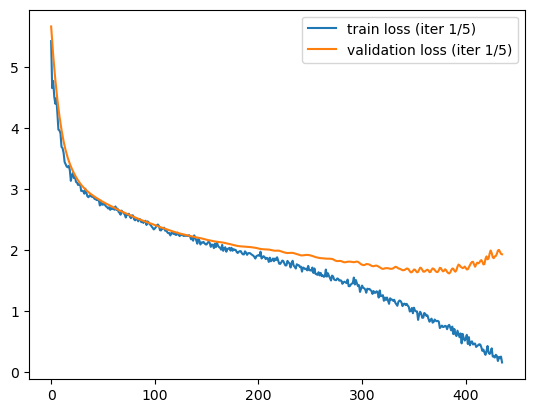

Surrogate vs Simulator y-space C2ST AUC Iteration: 0: 0.8667999999999999
Surrogate vs Simulator y-space SWD AUC Iteration: 0: 0.6016675233840942
Epoch x Chunk: 0, Weighted Loss: 5.159748906472288, Entropy loss: 5.159748906472288, Wasser loss: -0.6579155921936035
Epoch x Chunk: 500, Weighted Loss: 0.19689554344710145, Entropy loss: 0.7938493968207689, Wasser loss: -0.05894183740019798
Epoch x Chunk: 1000, Weighted Loss: 0.1151848577261857, Entropy loss: 1.0837501329683183, Wasser loss: -0.29991456866264343
Epoch x Chunk: 1500, Weighted Loss: -0.01118085456669038, Entropy loss: 0.8920676925691984, Wasser loss: -0.3982873857021332
Epoch x Chunk: 2000, Weighted Loss: -0.025358536954534106, Entropy loss: 0.9231378959501226, Wasser loss: -0.43185704946517944
Epoch x Chunk: 2500, Weighted Loss: 0.0023856717210181677, Entropy loss: 0.9995777864958955, Wasser loss: -0.4249823987483978
Training loss did not improve. Stopped training after 2577 epochs x chunks.
y c2st AUC on simulator: 0.79275000

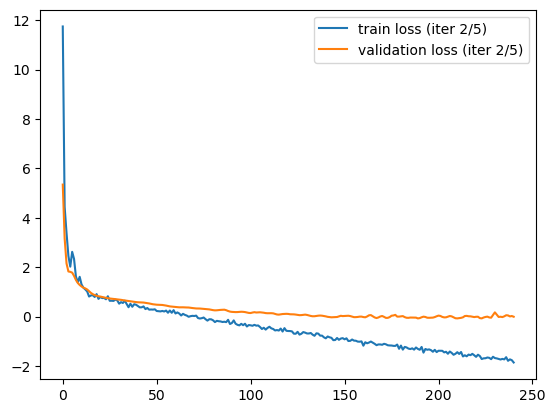

Surrogate vs Simulator y-space C2ST AUC Iteration: 1: 0.7075
Surrogate vs Simulator y-space SWD AUC Iteration: 1: 0.15926440060138702
Epoch x Chunk: 0, Weighted Loss: 0.9203758592890834, Entropy loss: 0.9203758592890834, Wasser loss: -0.49556687474250793
Epoch x Chunk: 500, Weighted Loss: -0.0202932094129451, Entropy loss: 0.6665577111709604, Wasser loss: -0.31465789675712585
Epoch x Chunk: 1000, Weighted Loss: -0.8796009168964627, Entropy loss: 3.1497682717395508, Wasser loss: -2.606473445892334
Epoch x Chunk: 1500, Weighted Loss: -0.938993315745904, Entropy loss: 3.2195587307737314, Wasser loss: -2.7212300300598145
Epoch x Chunk: 2000, Weighted Loss: -0.9905584330288176, Entropy loss: 3.288181732260713, Wasser loss: -2.8243043422698975
Training loss did not improve. Stopped training after 2446 epochs x chunks.
y c2st AUC on simulator: 0.5972999999999999
y c2st AUC on surrogate: 0.57165
Source c2st AUC: 0.9042
--__----__----__----__----__----__----__----__----__----__--
ITERATION: 3/5

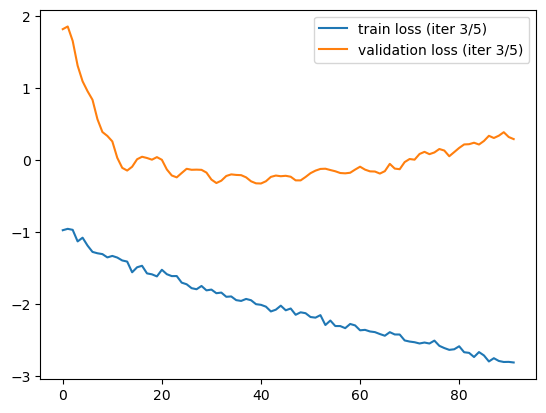

Surrogate vs Simulator y-space C2ST AUC Iteration: 2: 0.6291
Surrogate vs Simulator y-space SWD AUC Iteration: 2: 0.12141530960798264
Epoch x Chunk: 0, Weighted Loss: 3.261542205112675, Entropy loss: 3.261542205112675, Wasser loss: -2.519498109817505
Epoch x Chunk: 500, Weighted Loss: -0.056003000828510036, Entropy loss: 0.5845208349918805, Wasser loss: -0.33051323890686035
Epoch x Chunk: 1000, Weighted Loss: -1.5762276473916597, Entropy loss: 3.3605296656354975, Wasser loss: -3.6919808387756348
Epoch x Chunk: 1500, Weighted Loss: -1.6326699807506042, Entropy loss: 3.329786938483294, Wasser loss: -3.759437322616577
Epoch x Chunk: 2000, Weighted Loss: -1.5651390664583358, Entropy loss: 3.453026438034546, Wasser loss: -3.7157814502716064
Epoch x Chunk: 2500, Weighted Loss: -1.6102555264048863, Entropy loss: 3.36040229523799, Wasser loss: -3.740537643432617
Epoch x Chunk: 3000, Weighted Loss: -1.6205077227863467, Entropy loss: 3.245418718668142, Wasser loss: -3.705904722213745
y c2st AUC 

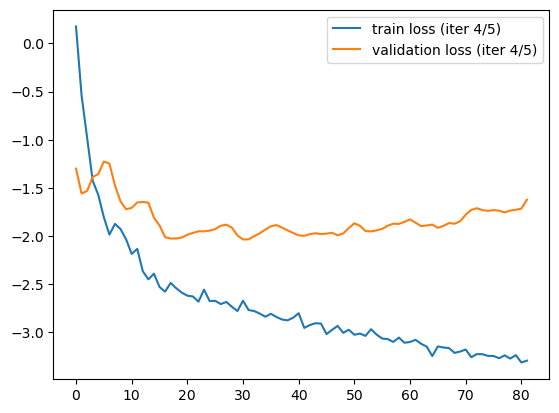

Surrogate vs Simulator y-space C2ST AUC Iteration: 3: 0.6012
Surrogate vs Simulator y-space SWD AUC Iteration: 3: 0.09803754836320877
Epoch x Chunk: 0, Weighted Loss: 3.3325746260533053, Entropy loss: 3.3325746260533053, Wasser loss: -3.103052854537964
Epoch x Chunk: 500, Weighted Loss: -0.0865843223259907, Entropy loss: 0.7588524560834449, Wasser loss: -0.44891440868377686
Epoch x Chunk: 1000, Weighted Loss: -1.6903880238621898, Entropy loss: 3.46418664992125, Wasser loss: -3.899491548538208
Epoch x Chunk: 1500, Weighted Loss: -1.8914478317831636, Entropy loss: 3.288573129122967, Wasser loss: -4.111456871032715
Epoch x Chunk: 2000, Weighted Loss: -1.7229444611380866, Entropy loss: 3.2680710088945455, Wasser loss: -3.8619511127471924
Epoch x Chunk: 2500, Weighted Loss: -1.9655045308027836, Entropy loss: 3.2089410813559747, Wasser loss: -4.18312406539917
Training loss did not improve. Stopped training after 2801 epochs x chunks.
y c2st AUC on simulator: 0.5375
y c2st AUC on surrogate: 0

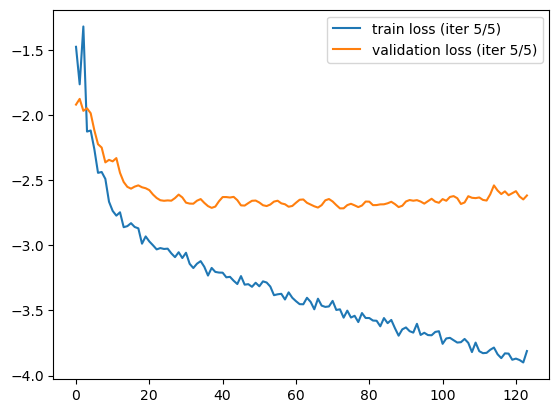

Surrogate vs Simulator y-space C2ST AUC Iteration: 4: 0.55465
Surrogate vs Simulator y-space SWD AUC Iteration: 4: 0.06714757531881332
Epoch x Chunk: 0, Weighted Loss: 3.2155871070727153, Entropy loss: 3.2155871070727153, Wasser loss: -4.026476860046387
Epoch x Chunk: 500, Weighted Loss: -0.2902847967060809, Entropy loss: 1.2044562942295736, Wasser loss: -0.9308881759643555
Epoch x Chunk: 1000, Weighted Loss: -1.912129951092853, Entropy loss: 3.2015335858144462, Wasser loss: -4.103700160980225
Epoch x Chunk: 1500, Weighted Loss: -1.9030422986346907, Entropy loss: 3.0678502092956004, Wasser loss: -4.0334248542785645
Training loss did not improve. Stopped training after 1516 epochs x chunks.
y c2st AUC on simulator: 0.5294
y c2st AUC on surrogate: 0.53425
Source c2st AUC: 0.8741
--__----__----__----__----__----__----__----__----__----__--


In [16]:
surro_train_domain_distribution = box_domain  # initialization
iteration = 0

# start loop here, don't initialize surrogate again!
for _ in range(NUMBER_OF_ITERATIONS):
    print(f"ITERATION: {iteration+1}/{NUMBER_OF_ITERATIONS} training with {MINIMUM_SAMPLES_PER_ITERATION} samples")
    surro_train_domain = surro_train_domain_distribution.sample(MINIMUM_SAMPLES_PER_ITERATION).detach()#?
    surro_train_push_forward = simulator.sample(surro_train_domain) # real simulator, budget
    

    train_dataset, val_dataset = create_train_val_dataloaders(
        surro_train_push_forward, # observations: x
        surro_train_domain,       #   parameters: θ
    )

    train_loss, val_loss = fit_conditional_normalizing_flow(
        network=surrogate,
        optimizer=surro_optimizer,
        training_dataset=train_dataset,
        validation_dataset=val_dataset,
        nb_epochs=cfg.surrogate.nb_epochs,#//NUMBER_OF_ITERATIONS, ## shall we cut down on epochs?
        early_stopping_patience=cfg.surrogate.early_stopping_patience,
        print_every=500,
    )
    
    
    if iteration == NUMBER_OF_ITERATIONS-1:
        # only save the final surrogate
        torch.save(
            surrogate.state_dict(),
            os.path.join(
                cfg.base.base_path, cfg.base.folder, f"{cfg.base.tag}_surrogate_{iteration}.pt"
            ),
        )
    
    plt.plot(train_loss, label=f"train loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.plot(val_loss, label=f"validation loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.legend()
    plt.show()
    
    # evaluate the current surrogate
    surrogate.eval()
    with torch.no_grad():
        # surrogate generated observations from the above 2 sets of 10k thetas
        gt_surrogate = surrogate.sample(size=cfg.source.num_obs, context=gt_source)
        gt_surrogate_two = surrogate.sample(size=cfg.source.num_eval_obs, context=gt_source_two)
    
    current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu()))
    current_swd = sliced_wasserstein_distance(gt_simulator, gt_surrogate,
                                              num_projections=4096, device=device
                                             ).item()
    
    print(f"Surrogate vs Simulator y-space C2ST AUC Iteration: {iteration}: {current_c2st}")
    print(f"Surrogate vs Simulator y-space SWD AUC Iteration: {iteration}: {current_swd}")
    
    
    # now fit a source with this new surrogate
    train_source(
        data=gt_simulator, # observations sampled using simulator.sample(context=gt_source)
        source_model=source,
        simulator=surrogate,  ##### ALWAYS PASSING SURROGATE HERE!!!
        optimizer=optimizer,
        entro_dist=None,  # default uniform is used
        kld_samples=cfg.source.num_kole_samples, # 512
        entro_lambda=schedule,
        wasser_p=cfg.source.wasserstein_order,   # 2
        wasser_np=cfg.source.wasserstein_slices, # 500
        use_log_sw=cfg.source.use_log_sw,   # True => log_or_id = torch.log
        num_chunks=cfg.source.num_chunks,   # 1
        epochs=cfg.source.pretraining_steps # 0
        + cfg.source.linear_decay_steps     # 500
        + cfg.source.lambda_steps,          # 3000
        min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
        early_stopping_patience=cfg.source.early_stopping_patience, # 500
        device=device,
        print_every=500,
    )
    
    # Evaluate trained source model
    source.eval()
    surrogate.eval()
    with torch.no_grad():
        # sample some θ-s from the estimated source
        estimated_source = source.sample(cfg.source.num_eval_obs)
        # sample some x-s from those θ-s from the surrogate (pushforward using surrogate)
        surro_estimated_pf = surrogate.sample(cfg.source.num_eval_obs, estimated_source)
        # sample some x-s from those θ-s from the actual simulator (pushforward using true simulator)
        simu_estimated_pf = simulator.sample(estimated_source)
    
    
    # Classifier two sample tests
    
    simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu(), ))
    print(f"y c2st AUC on simulator: {simu_c2st}")
    
    surro_c2st = np.mean(
        c2st_scores(
            surro_estimated_pf.cpu(),
            gt_surrogate.cpu(),
        )
    )
    print(f"y c2st AUC on surrogate: {surro_c2st}")
    
    source_c2st = np.mean(
        c2st_scores( # samples of thetas
            estimated_source.cpu(),
            gt_source_two.cpu(),
        )
    )
    print(f"Source c2st AUC: {source_c2st}")
    
    
    ## update the source for next iteration of updating the surrogate
    iteration += 1
    surro_train_domain_distribution = source
    print("--__--"*10)

In [17]:
torch.cuda.empty_cache()

In [19]:
# !nvidia-smi